In [1]:
# import de bibliotecas padrão
from pathlib import Path
import pandas as pd
import tarfile

### Passo 1: Análise Exploratória dos Dados

In [2]:
df = pd.read_csv("../data/raw/housing.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
# analisando a única feature categórica da base de dados
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

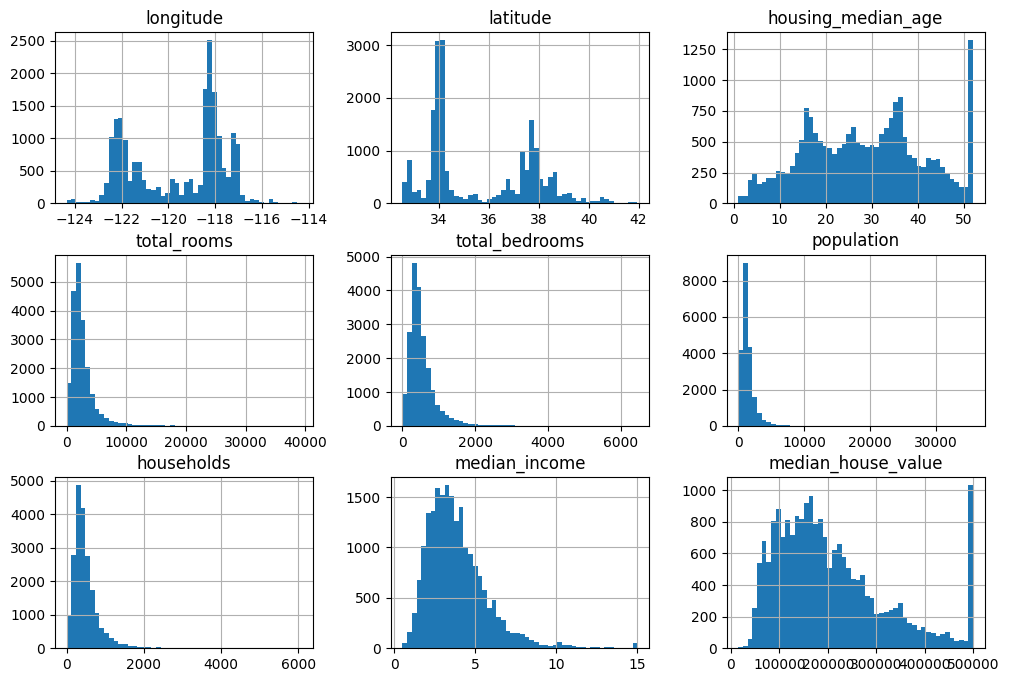

In [5]:
# analisando as features numéricas
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(12, 8))
plt.show()

In [6]:
# função para separar os dados em treino e teste
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [7]:
# chamada da função
train_set, test_set = shuffle_and_split_data(df, 0.2)

In [8]:
len(train_set)

16512

In [9]:
len(test_set)

4128

In [13]:
# fazendo a mesma coisa, porém com o uso de uma função importada do scikit-learn
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [14]:
# divide a renda média em stratum, ou seja, subdivisões cuja intenção é 
# garantir que a amostra seja representativa da população e não seja enviesada
df["income_cat"] = pd.cut(df["median_income"],
bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
labels=[1, 2, 3, 4, 5])

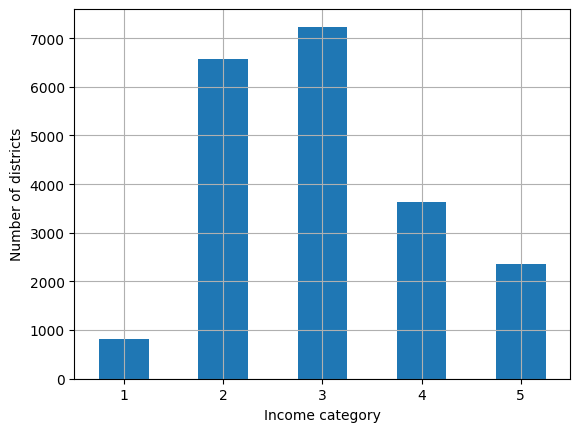

In [15]:
# mostra a quantidade de distritos por categorias de renda
df["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [16]:
# gera 10 divisões estratificadas dos dados do dataset para dividi-los em treino e teste
# from sklearn.model_selection import StratifiedShuffleSplit

# splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
# strat_splits = []
# for train_index, test_index in splitter.split(df, df["income_cat"]):
#     strat_train_set_n = df.iloc[train_index]
#     strat_test_set_n = df.iloc[test_index]
#     strat_splits.append([strat_train_set_n, strat_test_set_n])

In [17]:
# gera apenas uma divisão dos dados, sendo o primeiro índice
# strat_train_set, strat_test_set = strat_splits[0]

In [18]:
# forma convencional de se gerar os dados estratificados em treino e teste
strat_train_set, strat_test_set = train_test_split(
df, test_size=0.2, stratify=df["income_cat"], random_state=42)

In [19]:
# analisando as proporções da categoria de renda no set de teste
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [20]:
# como a feature "income_cat" foi usada para estratificar os dados, ela não é mais necessária
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### Passo 2: Análise de Dados

In [21]:
# boa prática que consiste em criar uma cópia dos dados de treino
# para manipulá-los sem alterar os originais
df = strat_train_set.copy()

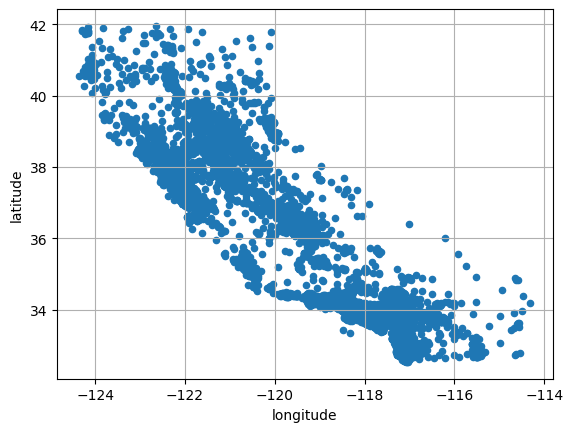

In [22]:
df.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.show()

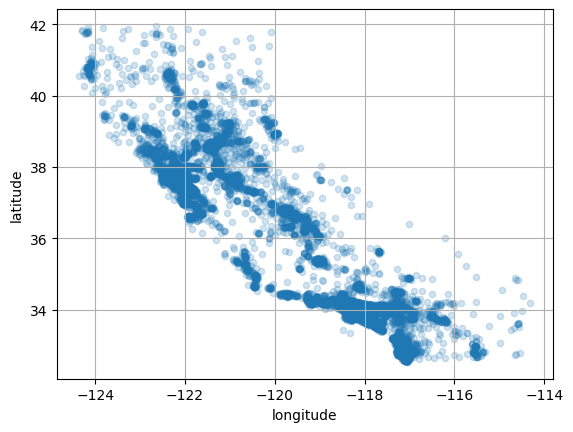

In [23]:
# melhorando a visualização do gráfico
df.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

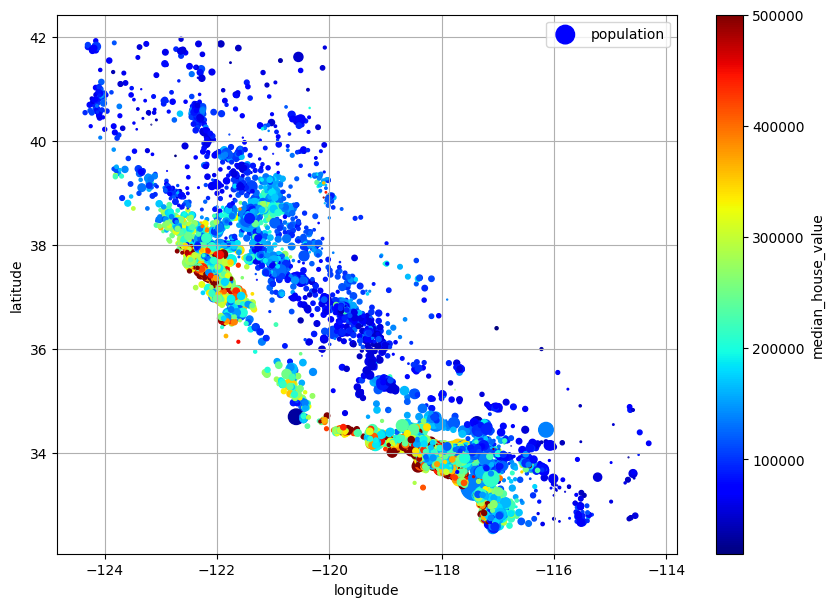

In [24]:
# correlação entre a densidade populacional e o preço médio das casas
df.plot(kind="scatter", x="longitude", y="latitude", grid=True,
    s=df["population"] / 100, label="population",
    c="median_house_value", cmap="jet", colorbar=True,
    legend=True, sharex=False, figsize=(10, 7))
plt.show()

In [25]:
# buscando correlações entre as features
corr_matrix = df.corr(numeric_only=True).round(2)

In [26]:
# correlação entre o preço médio das casas e as outras features
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.00
median_income         0.69
total_rooms           0.14
housing_median_age    0.11
households            0.06
total_bedrooms        0.05
population           -0.03
longitude            -0.05
latitude             -0.14
Name: median_house_value, dtype: float64

<Axes: xlabel='median_income', ylabel='median_house_value'>

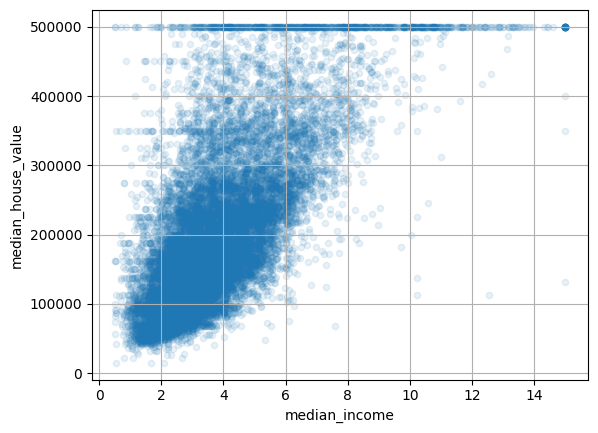

In [27]:
df.plot(kind="scatter", x="median_income", y="median_house_value",
alpha=0.1, grid=True)

In [28]:
# criando novas features com mais sentido para o treinamento do modelo
# exemplo: o número de quartos não é tão útil comparado ao número de cômodos
# assim como o número de cômodos deveria ser equiparado ao número de moradores
df["rooms_per_house"] = df["total_rooms"] / df["households"]
df["bedrooms_ratio"] = df["total_bedrooms"] / df["total_rooms"]
df["people_per_house"] = df["population"] / df["households"]

In [29]:
corr_matrix = df.corr(numeric_only=True).round(2)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.00
median_income         0.69
rooms_per_house       0.15
total_rooms           0.14
housing_median_age    0.11
households            0.06
total_bedrooms        0.05
people_per_house     -0.02
population           -0.03
longitude            -0.05
latitude             -0.14
bedrooms_ratio       -0.26
Name: median_house_value, dtype: float64

### Passo 3: Preparando os Dados

In [30]:
# separando as predições das labels
df = strat_train_set.drop("median_house_value", axis=1)
df_labels = strat_train_set["median_house_value"].copy()

In [31]:
df.shape

(16512, 9)

In [32]:
df_labels.shape

(16512,)

### Passo 4: Limpando os Dados (Data Cleaning)

In [33]:
# examples of handling missing values, but the best way of handling them is to use SimpleImputer from sklearn

# df.dropna(subset=["total_bedrooms"], inplace=True) # option 1
# df.drop("total_bedrooms", axis=1) # option 2
# median = df["total_bedrooms"].median() # option 3
# df["total_bedrooms"].fillna(median, inplace=True)

In [34]:
# "imputation" é o nome dado ao processo de preencher valores faltantes com algum dado
from sklearn.impute import SimpleImputer

#nesse caso, estamos preenchendo os valores faltantes com a mediana
imputer = SimpleImputer(strategy="median")

In [35]:
df_num = df.select_dtypes(include=[np.number])

In [36]:
imputer.fit(df_num)

SimpleImputer(strategy='median')

In [37]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [38]:
df_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [39]:
X = imputer.transform(df_num)

In [40]:
df_tr = pd.DataFrame(X, columns=df_num.columns,
index=df_num.index)

### Passo 5: Trabalhando com Features Categóricas

In [41]:
df_cat = df[["ocean_proximity"]]
df_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [42]:
df.shape

(16512, 9)

In [43]:
df_labels.shape

(16512,)

In [44]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
df_cat_1hot = cat_encoder.fit_transform(df_cat)

In [45]:
df_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [46]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [47]:
df_output = pd.DataFrame(df_cat_1hot.toarray(),
                        columns=cat_encoder.categories_[0])

In [48]:
df_output.head(10)

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0
6,1.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0


### Passo 6: Feature Scaling

In [49]:
# normalização dos valores, pode ser afetado por outliers
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(df_num)

In [50]:
df_num.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964
1481,-122.04,37.96,28.0,1207.0,252.0,724.0,252.0,3.6964
18125,-122.03,37.33,23.0,4221.0,671.0,1782.0,641.0,7.4863
5830,-118.31,34.20,36.0,1692.0,263.0,778.0,278.0,5.0865
17989,-121.95,37.27,17.0,1330.0,271.0,408.0,258.0,1.7171
4861,-118.28,34.02,29.0,515.0,229.0,2690.0,217.0,0.4999


In [51]:
# padronização dos valores, menos afetado por outliers
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
df_num_std_scaled = std_scaler.fit_transform(df_num)

In [52]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(df[["housing_median_age"]], [[35]], gamma=0.1)

In [53]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()

scaled_labels = target_scaler.fit_transform(df_labels.to_frame())

model = LinearRegression()
model.fit(df[["median_income"]], scaled_labels)
some_new_data = df[["median_income"]].iloc[:5] # pretend this is new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

In [54]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                transformer=StandardScaler())
model.fit(df[["median_income"]], df_labels)
predictions = model.predict(some_new_data)

In [55]:
df_labels.shape

(16512,)

In [56]:
df.shape

(16512, 9)

### Passo 7: Trabalhando com Transformadores Personalizados

In [57]:
from sklearn.preprocessing import FunctionTransformer
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(df[["population"]])

In [58]:
# cálculo de similaridade Gaussiana feito anteriormente com rbf_kernel
rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(df[["housing_median_age"]])

In [59]:
# medindo a semelhança geográfica com a cidade de São Francisco
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(df[["latitude", "longitude"]])

In [60]:
# transformador de função que calcula a razão entre as duas colunas 0 e 1
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

In [61]:
# função de um transformador personalizado que pode ser treinado para os métodos fit() e transform()
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True): # no *args or **kwargs!
        self.with_mean = with_mean
    
    def fit(self, X, y=None): # y is required even though we don't use it
        X = check_array(X) # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1] # every estimator stores this in fit()
        return self # always return self!
    
    def transform(self, X):
        check_is_fitted(self) # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

In [62]:
# realizando a mesma função que a célula acima, porém com o KMeans no fit()
# e o rbf_kernel() no transform() para encontrar a similaridade entre os dados e os clusters
 
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [63]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(df[["latitude", "longitude"]], 
                                           sample_weight=df_labels)

In [64]:
similarities[:3].round(2)

array([[0.31, 0.  , 0.  , 0.9 , 0.  , 0.01, 0.  , 0.17, 0.  , 0.  ],
       [0.  , 0.12, 0.94, 0.  , 0.  , 0.  , 0.  , 0.  , 0.42, 0.  ],
       [0.  , 0.1 , 0.  , 0.  , 0.43, 0.  , 0.11, 0.  , 0.02, 0.1 ]])

### Passo 8: Pipelines de Transformação

In [65]:
# função do Scikit-Learn para ajudar no entendimento do pipeline
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

In [66]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [67]:
# análise das duas primeiras linhas do pipeline

df_num_prepared = num_pipeline.fit_transform(df_num)
df_num_prepared[:2].round(2)

array([[-0.94,  1.35,  0.03,  0.58,  0.64,  0.73,  0.56, -0.89],
       [ 1.17, -1.19, -1.72,  1.26,  0.78,  0.53,  0.72,  1.29]])

In [68]:
# usando a função get_feature_names_out() para obter os nomes das features
df_df_num_prepared = pd.DataFrame(df_num_prepared, 
                                  columns=num_pipeline.get_feature_names_out(), 
                                  index=df_num.index)

In [69]:
# função para selecionar as colunas numéricas e categóricas no pipeline

from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms", 
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"), 
                             OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([("num", num_pipeline, num_attribs), 
                                   ("cat", cat_pipeline, cat_attribs),])


In [70]:
# 
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)), 
    (cat_pipeline, make_column_selector(dtype_include=object)),)

In [71]:
df_prepared = preprocessing.fit_transform(df)

In [72]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"] # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name), 
        StandardScaler())


log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"), 
                                     StandardScaler())

preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
    "households", "median_income"]),
    ("geo", cluster_simil, ["latitude", "longitude"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
],
remainder=default_num_pipeline) # one column remaining: housing_median_age

In [73]:
df_prepared = preprocessing.fit_transform(df)

In [74]:
df_prepared.shape

(16512, 24)

In [75]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

## Passo 9: Selecionando e Treinando o Melhor Modelo

In [76]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(df, df_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000019A3F619AD0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [77]:
df_predictions = tree_reg.predict(df)

In [78]:
from sklearn.metrics import mean_squared_error

tree_rmse = mean_squared_error(df_labels, df_predictions, squared=False)
tree_rmse

d:\bre_p\bre_p\Documents\housing-prices\env\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.0

In [79]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, df, df_labels, scoring="neg_root_mean_squared_error", cv=10)

In [80]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     67647.011686
std       2618.727162
min      62118.730843
25%      66507.187013
50%      67683.168086
75%      69195.573829
max      71245.511226
dtype: float64

In [81]:
# gera um score com os valores trocados, pois o resultado cross_val é negativo
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, df, df_labels, scoring="neg_root_mean_squared_error", cv=10)

In [82]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     47312.610363
std       2389.010891
min      43953.861521
25%      45204.357208
50%      47543.079416
75%      49125.194763
max      50894.978865
dtype: float64

### Passo 10: Otimização de Hiperparâmetros

In [83]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])

param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10], 
     'random_forest__max_features': [4, 6, 8]}, 
     {'preprocessing__geo__n_clusters': [10, 15], 
      'random_forest__max_features': [6, 8, 10]},
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
scoring='neg_root_mean_squared_error')
grid_search.fit(df, df_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000019A3F619AD0>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [84]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [85]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
# change column names to fit on this page, and show rmse = -score
cv_res.head() # note: the 1st column is the row ID

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__geo__n_clusters,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
12,4.478945,0.048061,0.114401,0.012688,15,6,"{'preprocessing__geo__n_clusters': 15, 'random...",-43400.034636,-44391.923270,-45305.933008,-44365.963638,778.296250,1
13,5.782371,0.072213,0.105581,0.001104,15,8,"{'preprocessing__geo__n_clusters': 15, 'random...",-43661.540847,-44560.545661,-45757.825926,-44659.970812,858.687682,2
14,7.152078,0.152055,0.161043,0.079684,15,10,"{'preprocessing__geo__n_clusters': 15, 'random...",-44231.181354,-44943.826696,-46159.793007,-45111.600352,796.239799,3
7,4.491684,0.117923,0.111120,0.001708,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-44586.925050,-45256.614625,-46253.257702,-45365.599126,684.628533,4
9,4.513121,0.108097,0.110775,0.000197,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-44586.925050,-45256.614625,-46253.257702,-45365.599126,684.628533,4


#### Randomized Search

In [86]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50), 
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3, 
                                scoring='neg_root_mean_squared_error', random_state=42)

In [87]:
rnd_search.fit(df, df_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000019A3F655D10>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000019A3F613890>},
                   random_state=42, scoring='neg_root_mean_squared_error')

### Passo 11: Analisando o melhor modelo

In [88]:
final_model = rnd_search.best_estimator_ # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.07, 0.06, 0.05, 0.01, 0.01, 0.01, 0.01, 0.18, 0.01, 0.02, 0.03,
       0.01, 0.01, 0.01, 0.02, 0.01, 0.  , 0.  , 0.02, 0.02, 0.01, 0.02,
       0.  , 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  ,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.  , 0.03, 0.01, 0.  , 0.08,
       0.  , 0.  , 0.  , 0.01])

In [89]:
sorted(zip(feature_importances, 
           final_model["preprocessing"].get_feature_names_out()), 
           reverse=True)

[(0.1813831690256434, 'log__median_income'),
 (0.08244502861607364, 'cat__ocean_proximity_INLAND'),
 (0.0718801580236537, 'bedrooms__ratio'),
 (0.05817301838233788, 'rooms_per_house__ratio'),
 (0.049517115363919215, 'people_per_house__ratio'),
 (0.03248219147637665, 'geo__Cluster 2 similarity'),
 (0.028221062269895562, 'geo__Cluster 43 similarity'),
 (0.022653278091252674, 'geo__Cluster 6 similarity'),
 (0.02198898088685375, 'geo__Cluster 15 similarity'),
 (0.021199799837403884, 'geo__Cluster 10 similarity'),
 (0.01773675216603871, 'geo__Cluster 11 similarity'),
 (0.016812078342102393, 'geo__Cluster 24 similarity'),
 (0.0166587519568679, 'geo__Cluster 13 similarity'),
 (0.015499668492902265, 'geo__Cluster 1 similarity'),
 (0.014115237838677923, 'geo__Cluster 23 similarity'),
 (0.01354873263940505, 'geo__Cluster 25 similarity'),
 (0.012858660059159845, 'geo__Cluster 0 similarity'),
 (0.012738526960538107, 'remainder__housing_median_age'),
 (0.012678159416906736, 'geo__Cluster 36 similar

### Passo 12: Avaliando o Modelo com a Base de Teste

In [90]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse) # prints 41424.40026462184

39565.359517373756


d:\bre_p\bre_p\Documents\housing-prices\env\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [91]:
from scipy import stats

confidence = 0.95

squared_errors = (final_predictions - y_test) ** 2

np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, 
                         loc=squared_errors.mean(), 
                         scale=stats.sem(squared_errors)))

array([37712.09234569, 41335.61948717])

### Passo 13: Finalizando com Deploy

In [92]:
import joblib
joblib.dump(final_model, "my_california_housing_model.pkl")

['my_california_housing_model.pkl']